CUSTOMER SEGMENTATION

In this project, my aim is to conduct unsupervised clustering analysis using the customer data stored in a groceries firm's database. Customer segmentation involves categorizing customers based on similarities within clusters. I'll create segments to enhance the relevance of each customer to the business, allowing for tailored product modifications that address diverse customer needs and behaviors. This approach not only optimizes customer significance but also enables the business to address the varied concerns of its customer base.

1. Importing Libraries

In [2]:
# Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys

# Ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set seed for reproducibility
np.random.seed(42)


2. Loading Data

In [3]:
df=pd.read_csv('D:/cognorise_assignment/Customer-personality-analysis/marketing_campaign.csv', sep="\t")
print("Number of datapoints:", len(df))
df.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


3. Plotting Some Features and Purging the Data

Within this segment, we'll delve into:

1. Data Cleansing
2. Feature Engineering

To gain a comprehensive understanding of the necessary procedures for refining the dataset, let's examine the data information closely.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

The findings indicate:

- Missing 'income' values exist.
- 'Dt_Customer' is not in DateTime format.
- Categorical features ('dtype: object') need numeric encoding.
To start, I'll drop rows with missing 'income' values.

In [7]:
# To remove missing values
data = df.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(df))

The total number of data-points after removing the rows with missing values are: 2240


The subsequent procedure involves generating a feature based on "Dt_Customer" to represent the duration of a customer's registration in the firm's database. This value will be relative to the most recent customer entry in the record. To obtain these values, I'll determine the time span between the newest and oldest recorded dates.

In [10]:
import pandas as pd

# Assuming df is your DataFrame
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], format='%d-%m-%Y')

dates = []
for i in df["Dt_Customer"]:
    try:
        i = i.date()
        dates.append(i)
    except AttributeError:
        pass

if dates:
    # Dates of the newest and oldest recorded customers
    print("The newest customer's enrollment date in the records:", max(dates))
    print("The oldest customer's enrollment date in the records:", min(dates))
else:
    print("No valid dates found in the 'Dt_Customer' column.")


The newest customer's enrollment date in the records: 2014-06-29
The oldest customer's enrollment date in the records: 2012-07-30


Creating a feature ("Customer_For") of the number of days the customers started to shop in the store relative to the last recorded date.

In [11]:
#Created a feature "Customer_For"
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
df["Customer_For"] = days
df["Customer_For"] = pd.to_numeric(df["Customer_For"], errors="coerce")

Now we will be exploring the unique values in the categorical features to get a clear idea of the data.

In [12]:
print("Total categories in the feature Marital_Status:\n", df["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", df["Education"].value_counts())

Total categories in the feature Marital_Status:
 Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature Education:
 Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64


Engineering new features by:

1. Deriving the "Age" of customers from their "Year_Birth."
2. Introducing "Spent," representing total expenses across various categories in a two-year span.
3. Crafting "Living_With" from "Marital_Status" to denote the living situation of couples.
4. Forming a "Children" feature, capturing the count of kids and teenagers in a household.
5. Introducing "Family_Size" for a clearer picture of household composition.
6. Establishing "Is_Parent" to indicate parenthood status.
7. Simplifying "Education" into three categories based on value counts.
8. Performing feature selection for refinement.

In [13]:
# Calculating age of customers
df["Age"] = 2021 - df["Year_Birth"]

# Total spending across categories
df["Spent"] = df[["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"]].sum(axis=1)

# Deriving living situation based on marital status
df["Living_With"] = df["Marital_Status"].replace({"Married": "Partner", "Together": "Partner", "Absurd": "Alone", "Widow": "Alone", "YOLO": "Alone", "Divorced": "Alone", "Single": "Alone"})

# Total children in the household
df["Children"] = df["Kidhome"] + df["Teenhome"]

# Calculating family size
df["Family_Size"] = df["Living_With"].replace({"Alone": 1, "Partner": 2}) + df["Children"]

# Identifying parenthood status
df["Is_Parent"] = (df["Children"] > 0).astype(int)

# Segmenting education levels
df["Education"] = df["Education"].replace({"Basic": "Undergraduate", "2n Cycle": "Undergraduate", "Graduation": "Graduate", "Master": "Postgraduate", "PhD": "Postgraduate"})

# Renaming columns for clarity
df = df.rename(columns={"MntWines": "Wines", "MntFruits": "Fruits", "MntMeatProducts": "Meat", "MntFishProducts": "Fish", "MntSweetProducts": "Sweets", "MntGoldProds": "Gold"})

# Dropping redundant features
columns_to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
df = df.drop(columns_to_drop, axis=1)

In [14]:
df.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2.240000e+03,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,...,0.064286,0.013393,0.009375,0.149107,3.054950e+16,52.194196,605.798214,0.950446,2.595089,0.715179
std,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,...,0.245316,0.114976,0.096391,0.356274,1.746339e+16,11.984069,602.249288,0.751803,0.906959,0.451430
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,25.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,1.561680e+16,44.000000,68.750000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,...,0.000000,0.000000,0.000000,0.000000,3.071520e+16,51.000000,396.000000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,4.570560e+16,62.000000,1045.500000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,...,1.000000,1.000000,1.000000,1.000000,6.039360e+16,128.000000,2525.000000,3.000000,5.000000,1.000000


3. Plotting some selected features and Purging Data

Relative Plot of Selected Features: A Data Subset


<Figure size 1000x400 with 0 Axes>

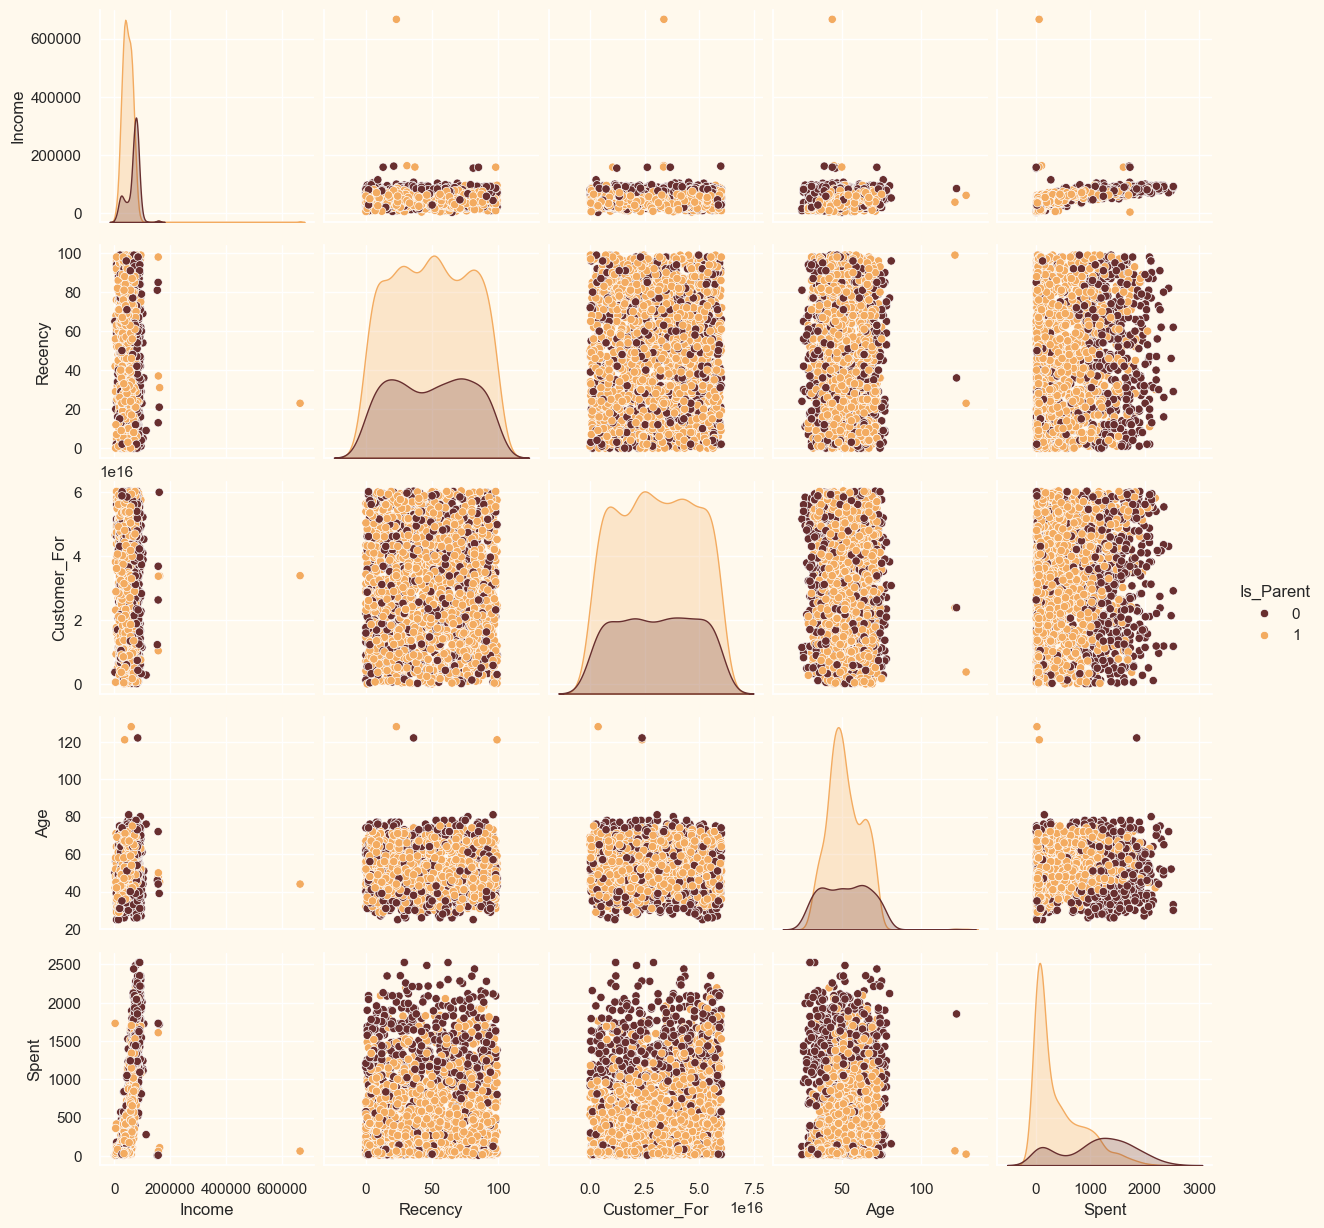

In [19]:
# Setting up color preferences
sns.set(rc={"axes.facecolor": "#FFF9ED", "figure.facecolor": "#FFF9ED"})
custom_palette = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
custom_cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

# Features to plot
selected_features = ["Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]

print("Relative Plot of Selected Features: A Data Subset")
plt.figure(figsize=(10, 4))
# Pairplot of selected features with 'Is_Parent' as hue
sns.pairplot(df[selected_features], hue="Is_Parent", palette=["#682F2F", "#F3AB60"])
plt.show()

Oulier removal

In [20]:
#Dropping the outliers by setting a cap on Age and income. 
df = df[(df["Age"]<90)]
df = df[(df["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(df))

The total number of data-points after removing the outliers are: 2212


Correlation matrix

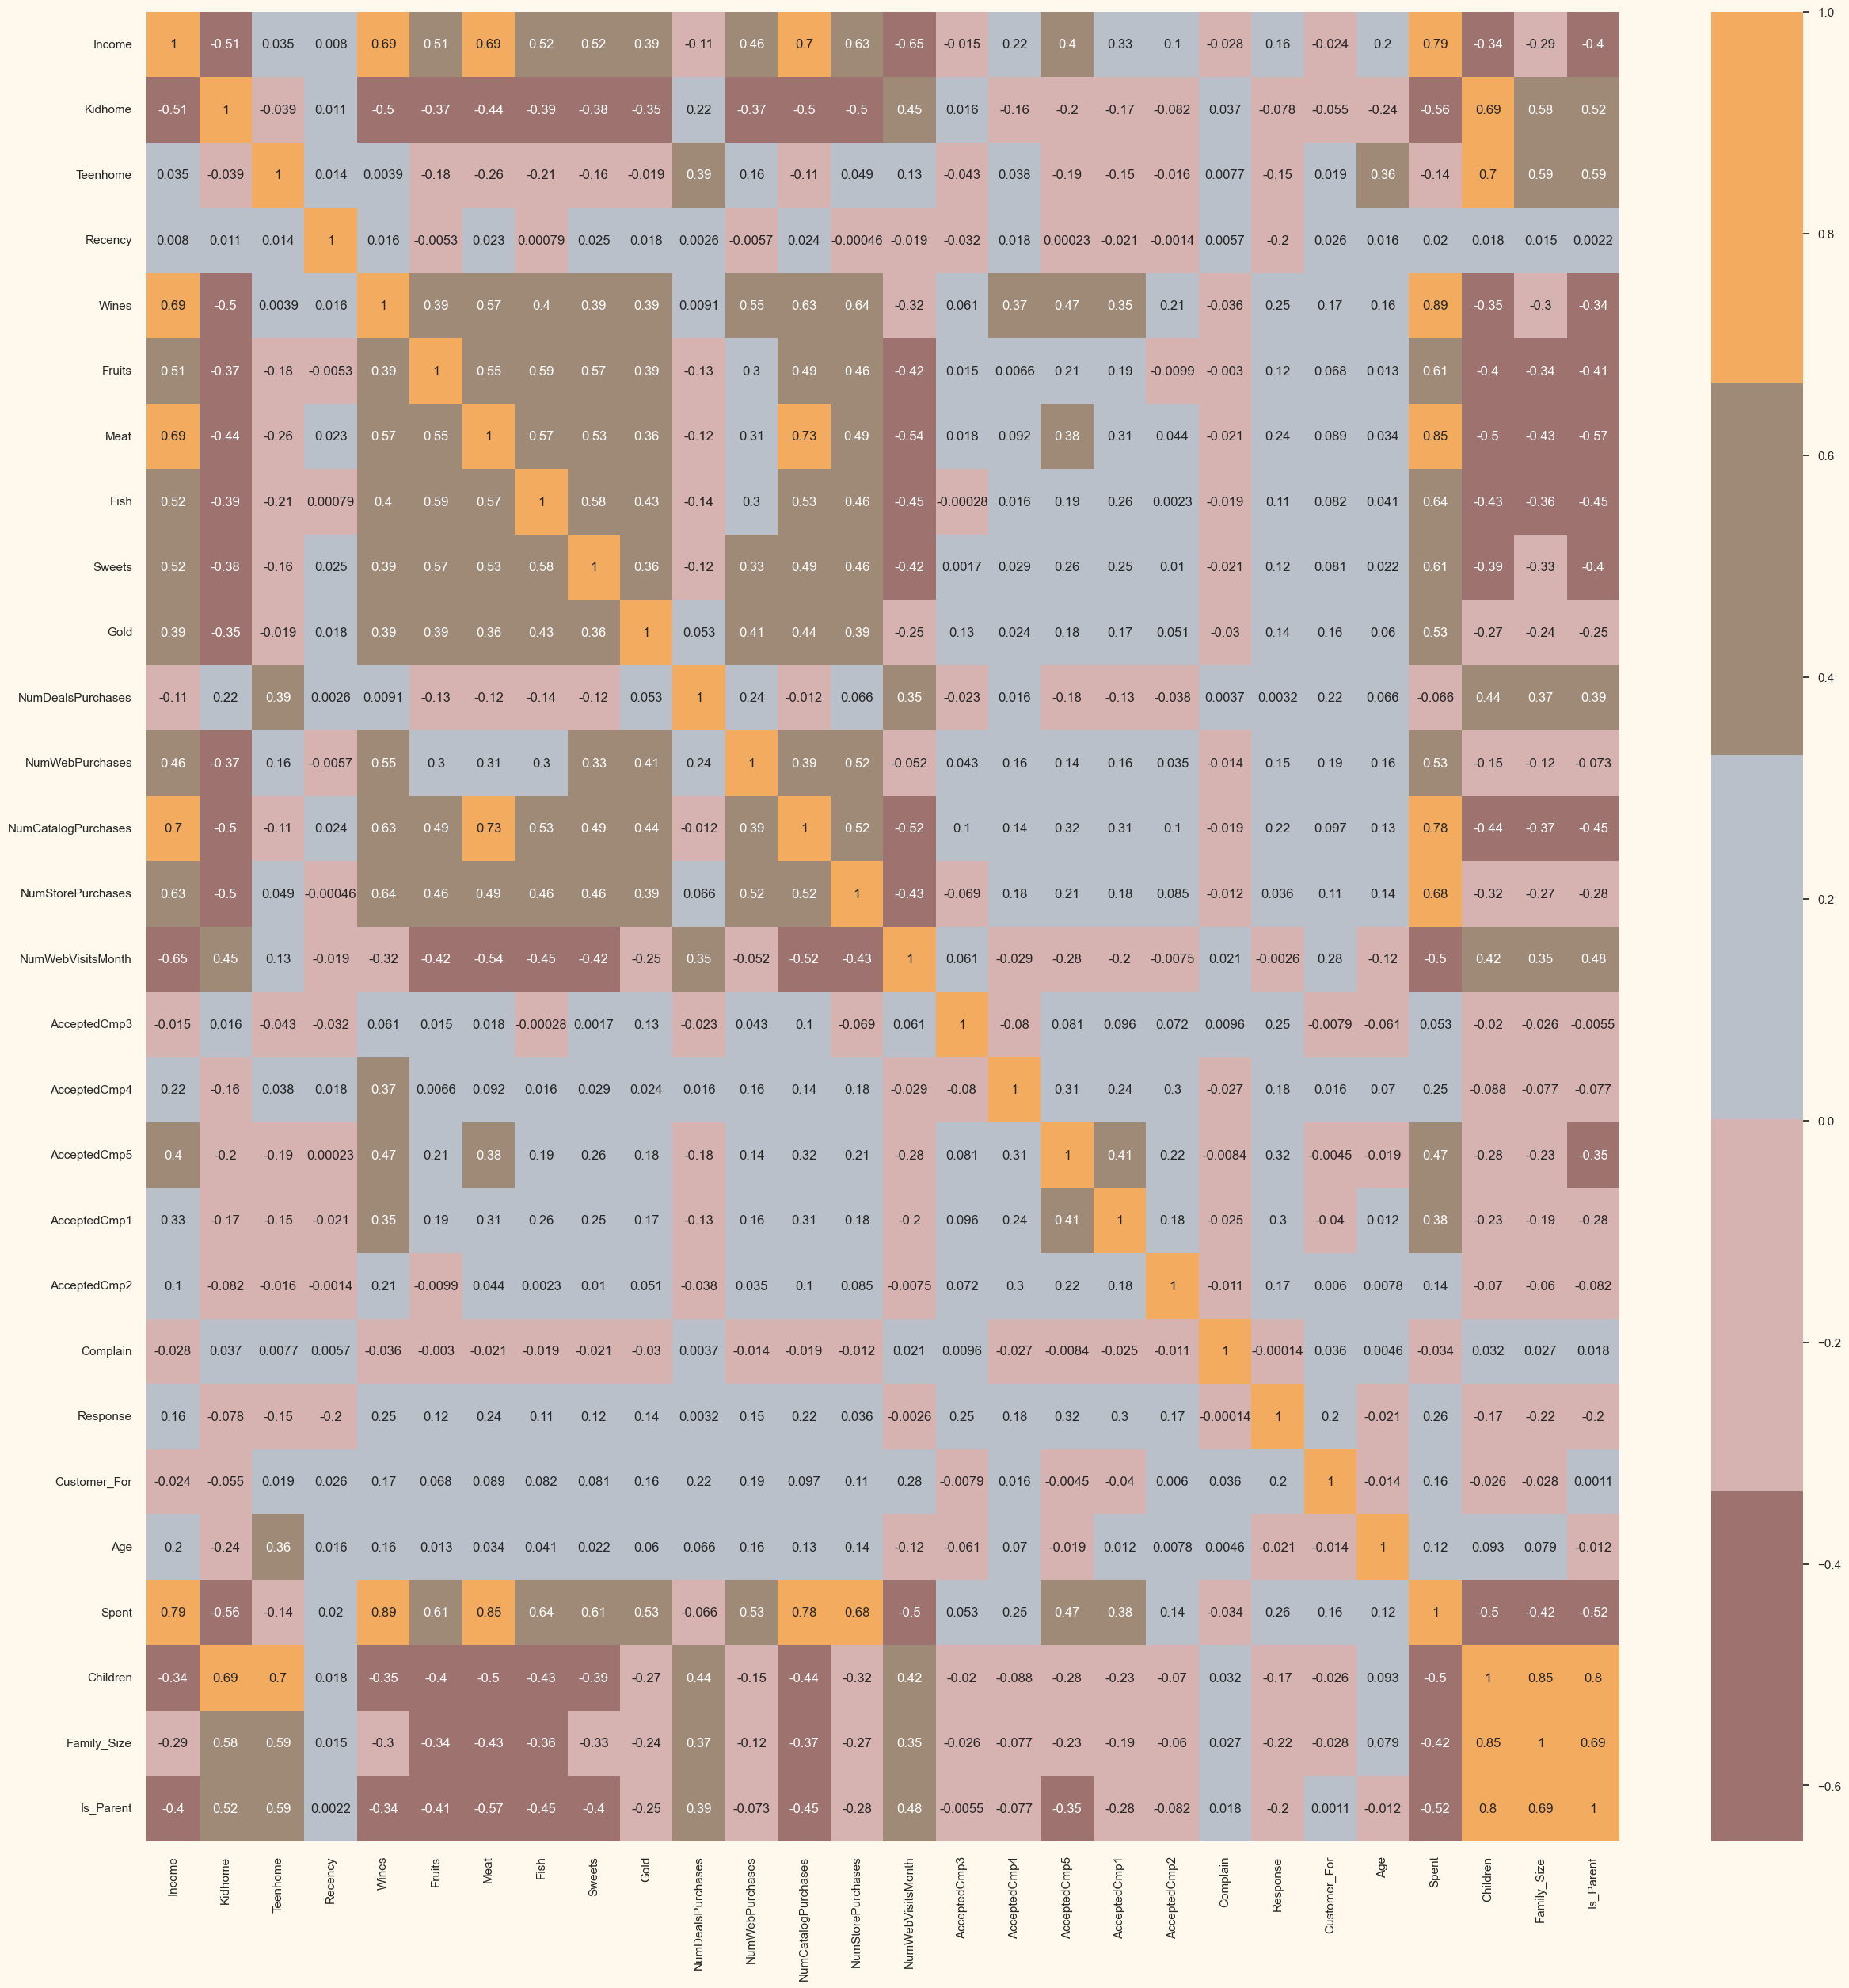

In [25]:
# Select only numeric columns for correlation calculation
numeric_columns = df.select_dtypes(include='number')

# Calculate the correlation matrix for numeric columns
corrmat = numeric_columns.corr()

# Plotting the heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(corrmat, annot=True, cmap=cmap, center=0)
plt.show()

4. Data Preprocessing

The data preprocessing involves the following procedures:

- Label encoding the categorical features.
- Scaling the features using the standard scaler.
- Creating a subset dataframe for dimensionality reduction.

In [26]:
# List of categorical variables
s = (df.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [27]:
# Label Encoding
LE=LabelEncoder()
for i in object_cols:
    df[i]=df[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [28]:
#Creating a copy of data
df1 = df.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
df1 = df1.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(df1)
scaled_df1 = pd.DataFrame(scaler.transform(df1),columns= df1.columns )
print("All features are now scaled")

All features are now scaled


In [29]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_df1.head()

Dataframe to be used for further modelling:


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.527721,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.206048,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


5. Dimensionality Reduction

To streamline classification, reducing numerous correlated and redundant features is crucial.
Dimensionality reduction via PCA enhances interpretability while minimizing information loss.
* Steps:
    - Use PCA for dimensionality reduction.
    - Visualize the reduced dataset.
    - Reduce dimensions to 3 for this project.

In [30]:
# Reducing features to 3
pca = PCA(n_components=3)
pca.fit(scaled_df1)
PCA_df1 = pd.DataFrame(pca.transform(scaled_df1), columns=(["col1","col2", "col3"]))
PCA_df1.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,3.854662e-17,2.878602,-5.978123,-2.539470,-0.781595,2.386380,7.452915
col2,2212.0,1.284887e-17,1.709469,-4.194757,-1.323932,-0.173716,1.234923,6.168185
col3,2212.0,5.862299e-17,1.231685,-3.625184,-0.853556,-0.051292,0.863841,6.746845


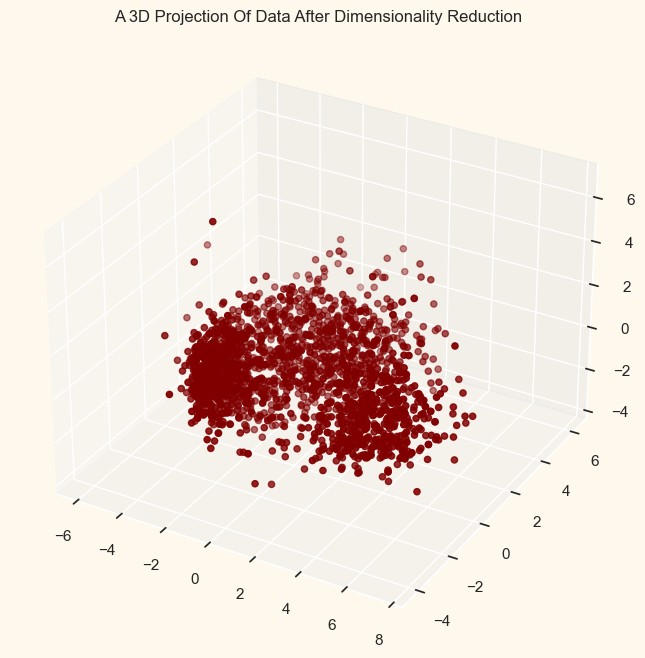

In [32]:
# 3D Projection Of Data after PCA
x =PCA_df1["col1"]
y =PCA_df1["col2"]
z =PCA_df1["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data After Dimensionality Reduction")
plt.show()

6. Agglomerative Clustering (Elbow Method)

With attributes reduced to three dimensions, I'll proceed with Agglomerative clustering, a hierarchical method that merges examples to achieve the desired number of clusters.
* Clustering steps:
    - Use the Elbow Method to determine the cluster count.
    - Employ Agglomerative Clustering for clustering.
    - Examine formed clusters via scatter plot.

Elbow Method to determine the number of clusters to be formed:


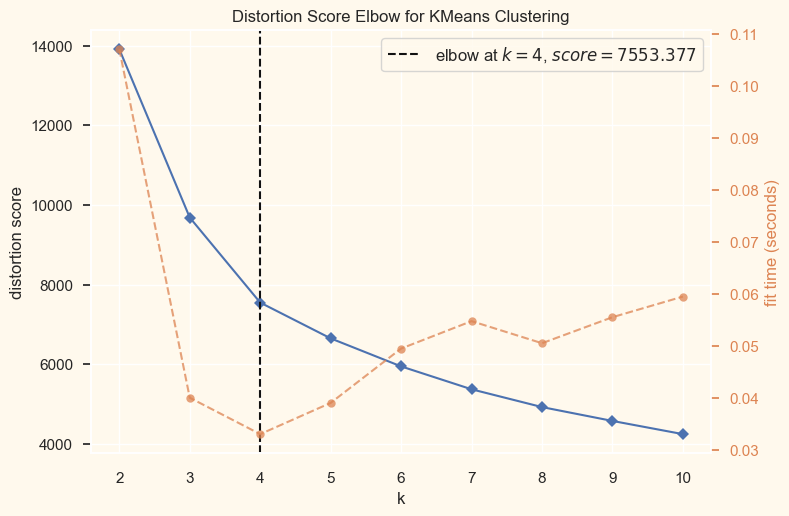

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [33]:
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_df1)
Elbow_M.show()

The previous cell suggests that 4 clusters will be optimal for this data. Moving forward, we'll fit the Agglomerative Clustering Model to obtain the final clusters.

In [38]:
# The Agglomerative Clustering model
AC = AgglomerativeClustering(n_clusters=4)

# Fit model and predict clusters on PCA_df1
yhat_AC = AC.fit_predict(PCA_df1)
PCA_df1["Clusters"] = yhat_AC

# Check and ensure lengths match before assigning clusters to 'df'
if len(PCA_df1) == len(df):
    # Adding the Clusters feature to the original dataframe
    df["Clusters"] = yhat_AC
else:
    print("Lengths of PCA_df1 and df don't match, handle this discrepancy before assigning clusters.")


3-D distribution of the clusters.

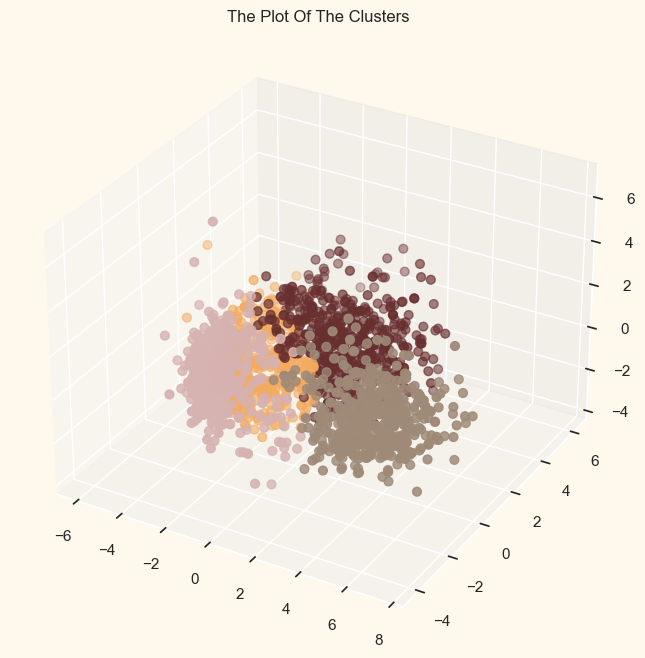

In [39]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_df1["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

7. Evaluating Models

As this clustering is unsupervised, there's no tagged feature available to evaluate or score our model. This section aims to analyze the patterns within the formed clusters and understand their nature.

To achieve this, we'll explore the data concerning the clusters through exploratory data analysis to draw insights.

Initially, let's examine the distribution of groups within the clustering.

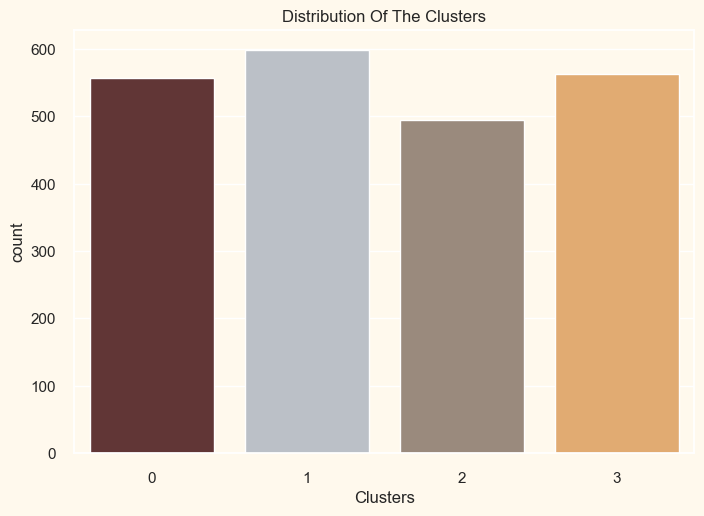

In [41]:
# Countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=df["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

The distribution across clusters appears to be quite balanced.

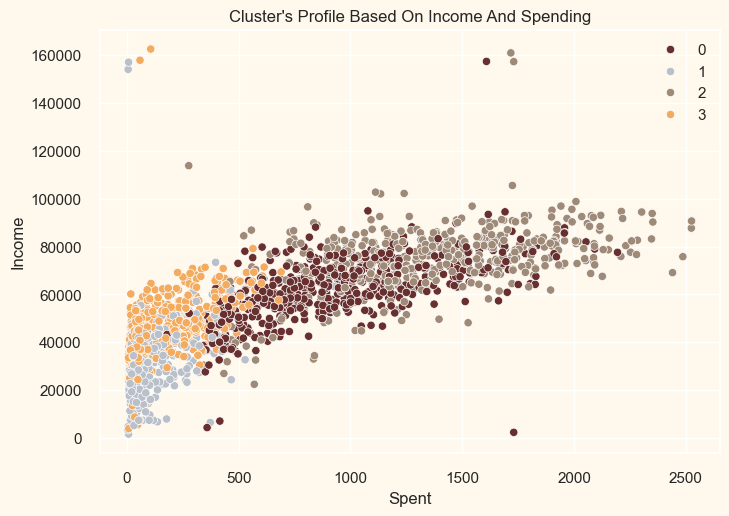

In [43]:
pl = sns.scatterplot(data=df, x="Spent", y="Income", hue="Clusters", palette=pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

The plot of Income versus Spending displays distinct patterns within the clusters:

- Group 0: Exhibits high spending and average income.
- Group 1: Shows high spending accompanied by high income.
- Group 2: Indicates low spending coupled with low income.
- Group 3: Displays high spending with low income.

Moving forward, I'll delve into the detailed distribution of clusters concerning various product categories in the dataset, namely: Wines, Fruits, Meat, Fish, Sweets, and Gold.

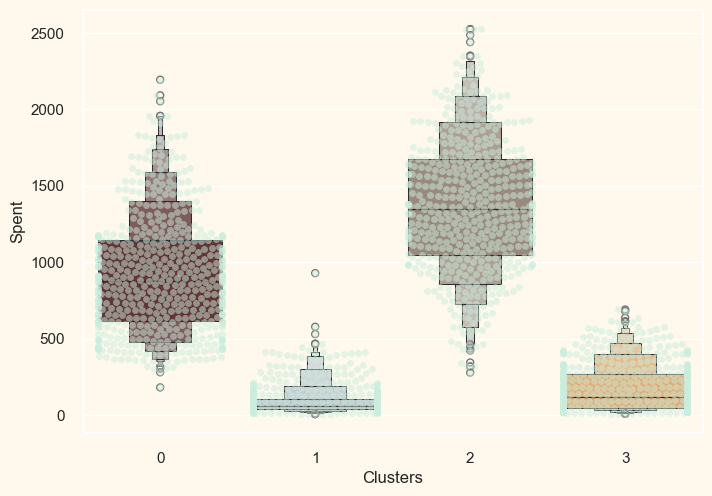

In [45]:
plt.figure()
pl = sns.swarmplot(x=df["Clusters"], y=df["Spent"], color="#CBEDDD", alpha=0.5)
pl = sns.boxenplot(x=df["Clusters"], y=df["Spent"], palette=pal)
plt.show()

8. Profiling

Having established the clusters and examined their buying behaviors, let's delve into the individuals within these clusters. We'll profile the formed clusters to identify the star customers and those who might require more attention from the retail store's marketing team.

To accomplish this, I'll plot certain features reflecting customers' personal characteristics aligned with their respective clusters. These insights will guide conclusions about customer segmentation and support decision-making.

<Figure size 800x550 with 0 Axes>

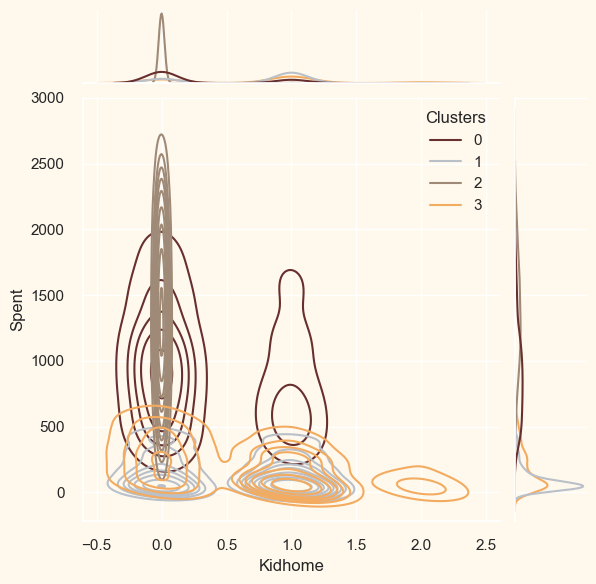

<Figure size 800x550 with 0 Axes>

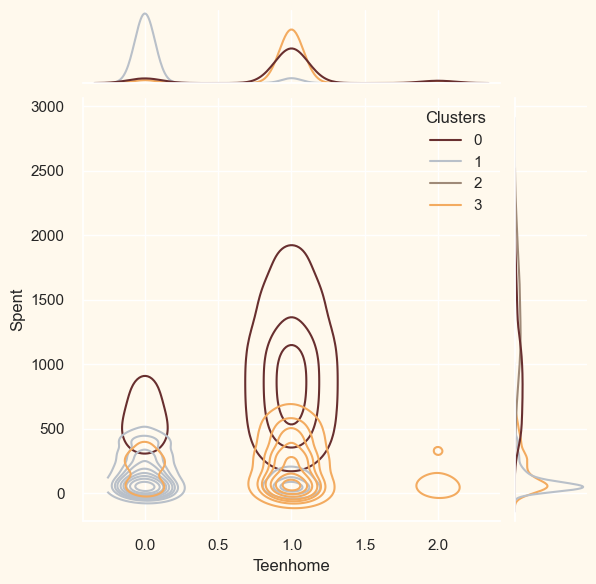

<Figure size 800x550 with 0 Axes>

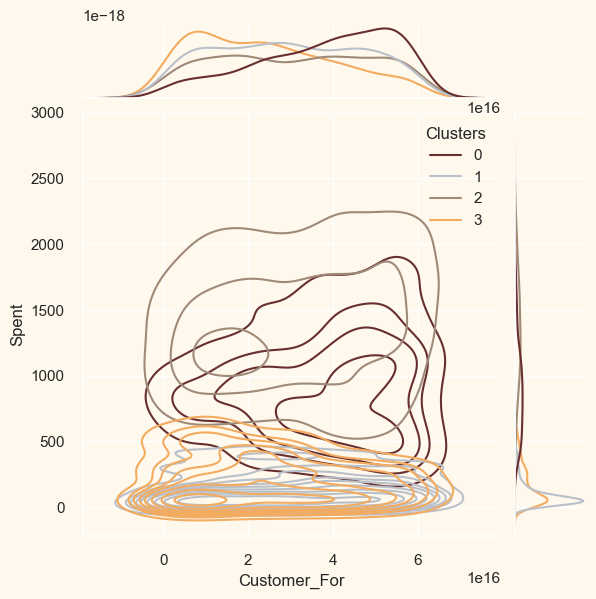

<Figure size 800x550 with 0 Axes>

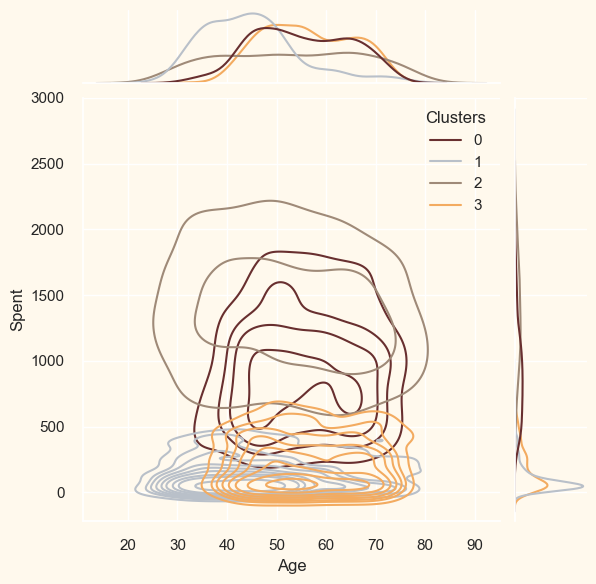

<Figure size 800x550 with 0 Axes>

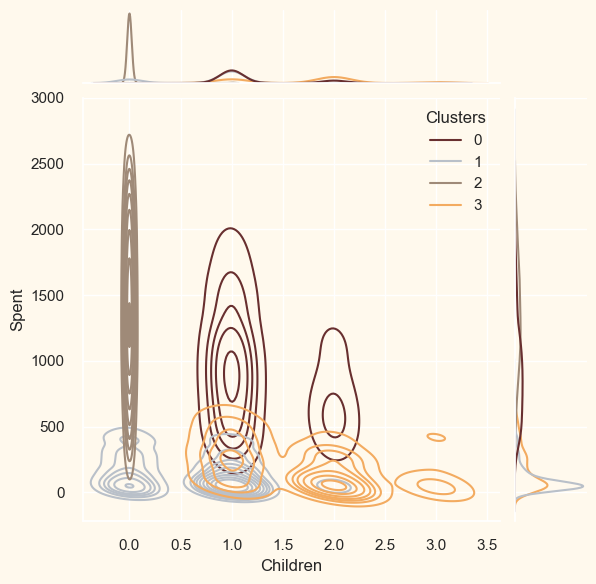

<Figure size 800x550 with 0 Axes>

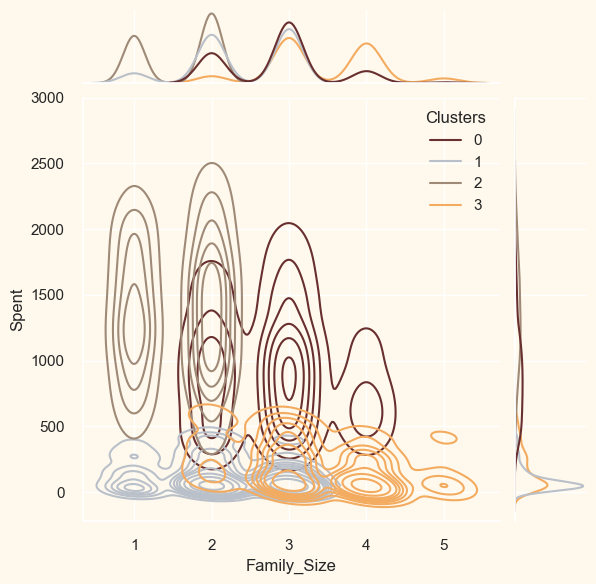

<Figure size 800x550 with 0 Axes>

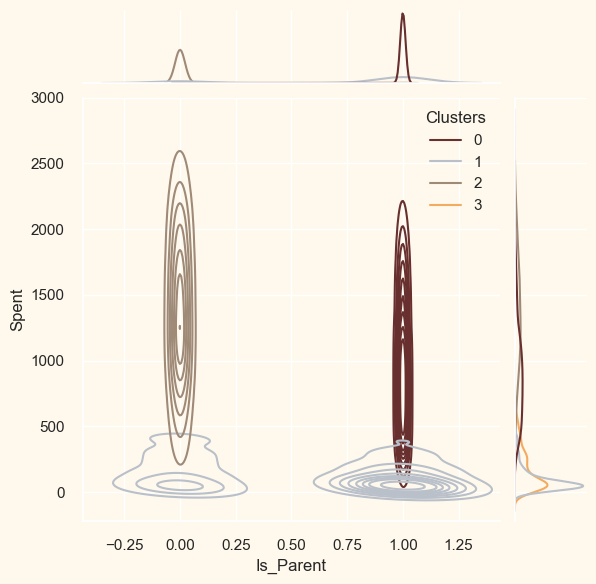

<Figure size 800x550 with 0 Axes>

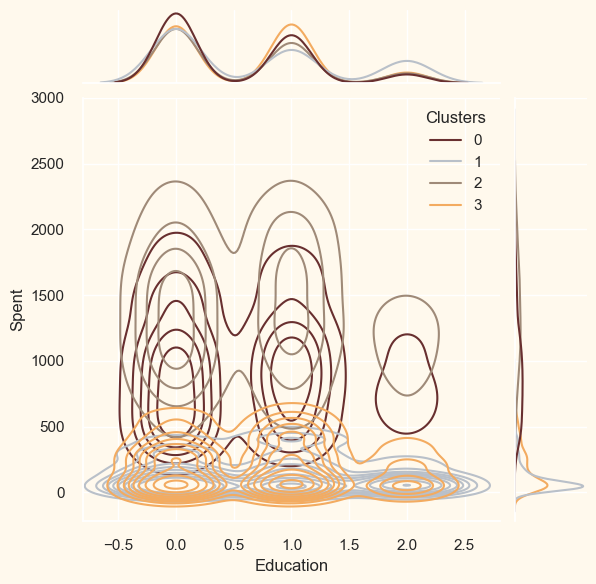

<Figure size 800x550 with 0 Axes>

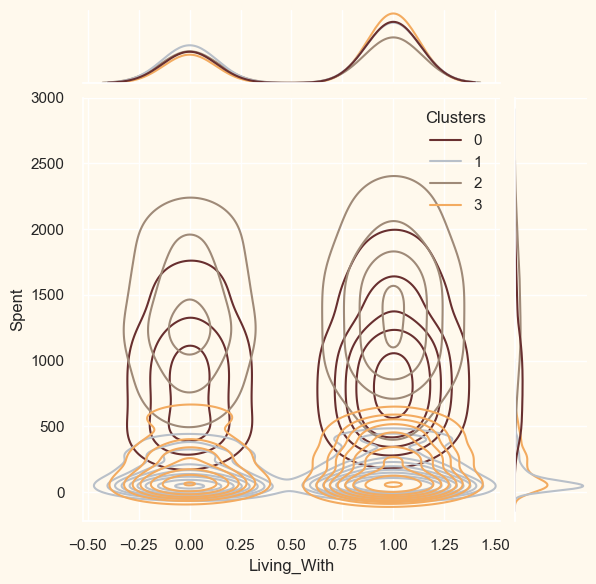

In [48]:
Personal = ["Kidhome", "Teenhome", "Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education", "Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=df[i], y=df["Spent"], hue=df["Clusters"], kind="kde", palette=pal)
    plt.show()

9. Summary

In this project, we embarked on unsupervised clustering, employing dimensionality reduction and subsequent agglomerative clustering. We identified 4 clusters and utilized them to profile customers based on their family compositions and income/spending patterns. These insights offer potential for refining marketing strategies.